In [1]:
!pip install pacmap shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=44df5cb6d26b6ccf76e693f5aa4904cabe6e1bc872672c7d8bf035c331a28037
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552451 sha256=bca96708771dee3c450f506d1fbd4a1e7ec425148cb7cdbbfc8d43dc8bd2c924
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built lime annoy


In [13]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import shap
import lime
from lime import lime_tabular
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
import pacmap

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Open and load the file from Drive
directory = '/content/drive/MyDrive/Colab Notebooks/Project/'
file_path = directory + 'Book2.csv'
with open(file_path) as f:
    data = pd.read_csv(f)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Columns: 188 entries, Samples to Val
dtypes: float64(185), int64(1), object(2)
memory usage: 138.2+ KB


,Samples,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,15298,Prostate cancer,AA,84.85,2.26,1.635,27.75,19.85,34.75,1.69,...,383.5,32.5,127.0,96.5,272.0,131.0,226.0,75.9,90.05,255.0
1,17585,Prostate cancer,EA,87.40,3.18,1.330,23.70,14.20,20.10,2.76,...,252.0,26.1,118.0,94.6,253.0,79.6,146.0,80.7,105.00,294.0
2,17848,Case control,EA,157.00,7.33,3.250,43.10,43.10,92.30,3.51,...,402.0,58.9,196.0,141.0,454.0,218.0,341.0,86.1,151.00,302.0
3,17893,Case control,EA,59.30,1.86,1.270,18.40,11.30,13.80,1.16,...,328.0,30.9,124.0,93.0,365.0,131.0,215.0,94.1,101.00,391.0
4,17962,Case control,EA,57.80,1.78,0.781,18.00,12.10,13.20,1.48,...,98.8,13.4,57.9,39.6,130.0,41.5,58.5,27.2,35.80,115.0


In [5]:
unique_status = data['Status'].unique()
print(unique_status)

df=data
df.head()

['Prostate cancer' 'Case control']


,Samples,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,15298,Prostate cancer,AA,84.85,2.26,1.635,27.75,19.85,34.75,1.69,...,383.5,32.5,127.0,96.5,272.0,131.0,226.0,75.9,90.05,255.0
1,17585,Prostate cancer,EA,87.40,3.18,1.330,23.70,14.20,20.10,2.76,...,252.0,26.1,118.0,94.6,253.0,79.6,146.0,80.7,105.00,294.0
2,17848,Case control,EA,157.00,7.33,3.250,43.10,43.10,92.30,3.51,...,402.0,58.9,196.0,141.0,454.0,218.0,341.0,86.1,151.00,302.0
3,17893,Case control,EA,59.30,1.86,1.270,18.40,11.30,13.80,1.16,...,328.0,30.9,124.0,93.0,365.0,131.0,215.0,94.1,101.00,391.0
4,17962,Case control,EA,57.80,1.78,0.781,18.00,12.10,13.20,1.48,...,98.8,13.4,57.9,39.6,130.0,41.5,58.5,27.2,35.80,115.0


In [6]:
df = data.copy()

# shuffling the df
shuffled_df = shuffle(df, random_state=42)

# Encoding catergorical data to numerical data
df['Race'] = df['Race'].map({'EA': 0, 'AA': 1})
df['Status'] = df['Status'].map({'Case control': 0, 'Prostate cancer': 1})

df.head()


,Samples,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,15298,1,1,84.85,2.26,1.635,27.75,19.85,34.75,1.69,...,383.5,32.5,127.0,96.5,272.0,131.0,226.0,75.9,90.05,255.0
1,17585,1,0,87.40,3.18,1.330,23.70,14.20,20.10,2.76,...,252.0,26.1,118.0,94.6,253.0,79.6,146.0,80.7,105.00,294.0
2,17848,0,0,157.00,7.33,3.250,43.10,43.10,92.30,3.51,...,402.0,58.9,196.0,141.0,454.0,218.0,341.0,86.1,151.00,302.0
3,17893,0,0,59.30,1.86,1.270,18.40,11.30,13.80,1.16,...,328.0,30.9,124.0,93.0,365.0,131.0,215.0,94.1,101.00,391.0
4,17962,0,0,57.80,1.78,0.781,18.00,12.10,13.20,1.48,...,98.8,13.4,57.9,39.6,130.0,41.5,58.5,27.2,35.80,115.0


In [20]:
# Check for NaN values
nan_check = df.isna().sum()
print(nan_check[nan_check > 0])

# Check total number of NaN values in df
total_nan = df.isna().sum().sum()
print("Total number of NaN values in the DataFrame (Before):", total_nan)

df.tail(10)

PC aa C34:4    1
PC aa C36:0    1
PC aa C36:1    1
PC aa C36:2    1
PC aa C36:3    1
              ..
Ser            1
Thr            2
Trp            1
Tyr            1
Val            1
Length: 160, dtype: int64
Total number of NaN values in the DataFrame (Before): 170


,Samples,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
84,20049,0,1,63.0,1.93,0.918,19.30,13.20,29.7,1.95,...,229.0,36.7,84.3,98.5,325.0,143.0,221.0,68.8,129.0,368.0
85,20051,0,1,90.3,2.41,1.470,26.10,14.80,22.3,1.79,...,307.0,40.1,123.0,82.7,209.0,134.0,167.0,81.1,101.0,340.0
86,20070,0,1,74.0,2.26,0.933,20.70,15.00,17.2,1.43,...,248.0,33.6,56.5,69.8,219.0,103.0,135.0,47.8,87.0,243.0
87,20078,0,1,109.5,2.36,1.635,35.75,16.85,24.7,1.87,...,108.0,10.5,65.0,37.2,65.4,50.6,NaN,23.5,31.7,107.0
88,20099,0,1,118.0,3.68,2.090,32.30,19.50,27.8,2.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,20103,0,1,137.0,3.00,2.390,47.20,23.50,41.5,2.44,...,207.0,22.9,99.1,68.5,200.0,98.0,111.0,60.4,63.1,213.0
90,20319,0,1,182.0,4.81,2.470,52.60,27.80,46.2,2.81,...,389.0,49.3,201.0,158.0,514.0,136.0,204.0,108.0,140.0,495.0
91,20323,0,1,150.0,3.46,2.260,55.00,29.70,61.0,3.81,...,312.0,29.5,143.0,117.0,330.0,94.6,155.0,87.4,75.2,348.0
92,20361,0,1,133.0,2.74,2.130,45.00,19.80,39.9,2.46,...,300.0,35.0,151.0,87.1,510.0,163.0,247.0,73.0,105.0,324.0
93,20752,0,1,212.0,6.19,2.730,55.10,30.60,40.8,3.61,...,355.0,27.9,170.0,113.0,328.0,153.0,187.0,84.3,86.6,450.0


In [21]:
import pandas as pd

# Assuming df is your DataFrame
columns_to_select = ['C14', 'C16:1-OH', 'C16-OH', 'C18:1-OH', 'C3-OH']

# Select the columns from the DataFrame
selected_columns = df[columns_to_select]
selected_columns.describe()

,C14,C16:1-OH,C16-OH,C18:1-OH,C3-OH
count,93.000000,93.000000,93.000000,93.000000,93.000000
mean,0.120774,0.056188,0.056817,0.064946,0.099425
std,0.380434,0.208267,0.208284,0.243052,0.303718
min,0.017000,0.007000,0.007000,0.009000,0.017000
25%,0.032000,0.010000,0.012000,0.014000,0.029000
50%,0.041000,0.012000,0.014000,0.017000,0.036000
75%,0.050000,0.015000,0.017000,0.019000,0.042000
max,2.300000,1.200000,1.430000,1.580000,1.630000


In [15]:
# List of columns to exclude
columns_to_exclude = ['Samples', 'Status', 'Race']

# Select all columns except the specified ones
df_filtered = df.drop(columns=columns_to_exclude)

summary_stats = df_filtered.describe().T
skewness = df_filtered.skew()
summary_stats['Skewness'] = skewness

file_path = os.path.join(directory, 'data_skewness.xlsx')
summary_stats.to_excel(file_path, index=False)
summary_stats

,count,mean,std,min,25%,50%,75%,max,Skewness
lysoPC a C16:0,94.0,116.785638,38.644902,54.300,90.1500,113.00,133.8750,279.0,1.155342
lysoPC a C16:1,94.0,3.559436,1.585756,0.827,2.5425,3.26,4.1950,11.7,1.991072
lysoPC a C17:0,94.0,2.823053,4.557468,0.781,1.4825,1.93,2.4625,33.3,5.453255
lysoPC a C18:0,94.0,35.902128,14.995508,16.200,26.9000,32.35,40.7250,107.0,2.202366
lysoPC a C18:1,94.0,22.447872,7.288133,11.000,16.8625,22.35,26.4000,43.1,0.648095
...,...,...,...,...,...,...,...,...,...
Ser,93.0,128.583871,37.520589,41.500,103.0000,131.00,153.0000,231.0,0.067945
Thr,92.0,177.722826,52.509888,57.000,143.2500,179.50,205.2500,341.0,0.400506
Trp,93.0,78.285484,23.466522,23.500,63.7000,77.90,91.6000,138.0,0.103403
Tyr,93.0,102.023118,32.015937,31.700,80.4000,97.40,122.0000,196.0,0.497219


ValueError: Yeo-Johnson input must be finite.

In [ ]:
# Filter rows where Status is "Prostate cancer" (1)
df1 = df[df['Status'] == 1]
df1

,Samples,Status,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,15298,1,0,84.85,2.260,1.635,27.75,19.85,34.75,1.690,...,383.5,32.50,127.00,96.5,272.0,131.0,226.0,75.90,90.05,255.0
1,17585,1,1,87.40,3.180,1.330,23.70,14.20,20.10,2.760,...,252.0,26.10,118.00,94.6,253.0,79.6,146.0,80.70,105.00,294.0
5,17985,1,0,118.00,2.950,2.420,34.80,23.80,41.90,3.050,...,338.0,53.10,142.00,126.0,389.0,169.0,230.0,91.40,186.00,411.0
13,18109,1,1,163.00,11.700,26.700,92.80,16.00,20.00,1.470,...,342.0,39.50,164.00,132.0,418.0,133.0,159.0,88.90,128.00,304.0
14,18130,1,1,134.00,6.010,2.600,34.50,25.60,31.20,4.850,...,399.0,37.60,172.00,122.0,332.0,144.0,146.0,62.00,111.00,399.0
18,18177,1,0,111.00,2.910,1.220,26.70,19.70,22.00,2.250,...,294.0,42.20,101.00,105.0,254.0,158.0,201.0,113.00,134.00,233.0
19,18183,1,0,106.00,2.690,1.470,35.90,28.70,37.80,1.840,...,275.0,38.90,124.00,109.0,320.0,146.0,184.0,41.80,121.00,302.0
21,18228,1,1,156.00,5.860,1.940,42.10,36.00,52.90,3.470,...,254.0,24.60,84.20,75.5,297.0,78.6,177.0,72.20,94.50,334.0
23,18262,1,1,54.60,2.140,8.120,28.50,15.20,17.50,1.470,...,290.0,29.50,146.00,104.0,236.0,160.0,171.0,86.80,91.00,249.0
27,18302,1,0,117.00,3.580,1.780,30.80,25.60,56.50,2.460,...,322.0,42.50,106.00,104.0,318.0,193.0,293.0,84.80,98.70,344.0


In [ ]:
df1 = df1.drop(columns=['Samples', 'Status'])
df1.head()

,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,lysoPC a C24:0,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
0,0,84.85,2.26,1.635,27.75,19.85,34.75,1.69,11.25,0.1595,...,383.5,32.5,127.0,96.5,272.0,131.0,226.0,75.9,90.05,255.0
1,1,87.40,3.18,1.330,23.70,14.20,20.10,2.76,10.20,0.1470,...,252.0,26.1,118.0,94.6,253.0,79.6,146.0,80.7,105.00,294.0
5,0,118.00,2.95,2.420,34.80,23.80,41.90,3.05,10.20,0.2170,...,338.0,53.1,142.0,126.0,389.0,169.0,230.0,91.4,186.00,411.0
13,1,163.00,11.70,26.700,92.80,16.00,20.00,1.47,5.00,65.0000,...,342.0,39.5,164.0,132.0,418.0,133.0,159.0,88.9,128.00,304.0
14,1,134.00,6.01,2.600,34.50,25.60,31.20,4.85,14.00,0.1330,...,399.0,37.6,172.0,122.0,332.0,144.0,146.0,62.0,111.00,399.0


# EDA

In [ ]:
df1.describe()

,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,lysoPC a C24:0,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,...,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,0.500000,115.848864,3.615227,2.661182,35.805682,22.414773,35.065909,2.577386,9.248523,2.004216,...,294.840909,37.264773,125.151136,102.597727,326.522727,137.095455,186.193182,84.644318,109.905682,335.761364
std,0.505781,30.718492,1.693878,3.874104,13.229571,6.367273,12.546994,0.953426,3.099663,9.999176,...,76.079271,11.407706,42.281778,24.303512,84.348457,33.980582,42.066284,21.216150,29.423156,87.146661
min,0.000000,54.600000,1.510000,0.912000,22.100000,11.400000,17.500000,1.090000,4.980000,0.094000,...,189.000000,22.100000,68.500000,62.600000,147.000000,77.900000,118.000000,41.800000,65.600000,216.000000
25%,0.000000,95.000000,2.690000,1.520000,28.050000,17.100000,24.700000,1.920000,7.422500,0.145500,...,237.750000,29.375000,96.262500,83.225000,274.250000,115.500000,155.250000,72.000000,88.775000,281.000000
50%,0.500000,112.000000,3.260000,1.900000,31.350000,21.900000,31.400000,2.352500,8.510000,0.168500,...,279.000000,35.000000,115.000000,98.100000,308.750000,133.500000,192.000000,80.800000,98.350000,303.500000
75%,1.000000,130.875000,4.068750,2.375000,39.750000,25.825000,43.600000,3.042500,10.525000,0.212500,...,338.000000,42.737500,143.000000,113.250000,386.500000,158.500000,207.250000,94.262500,131.750000,390.250000
max,1.000000,215.000000,11.700000,26.700000,92.800000,39.500000,63.600000,5.490000,22.300000,65.000000,...,539.000000,81.200000,264.000000,186.000000,577.000000,231.000000,307.000000,138.000000,196.000000,552.000000


In [ ]:
# Frequency counts for Race
print(df1['Race'].value_counts())

Race
0    22
1    22
Name: count, dtype: int64


Histogram

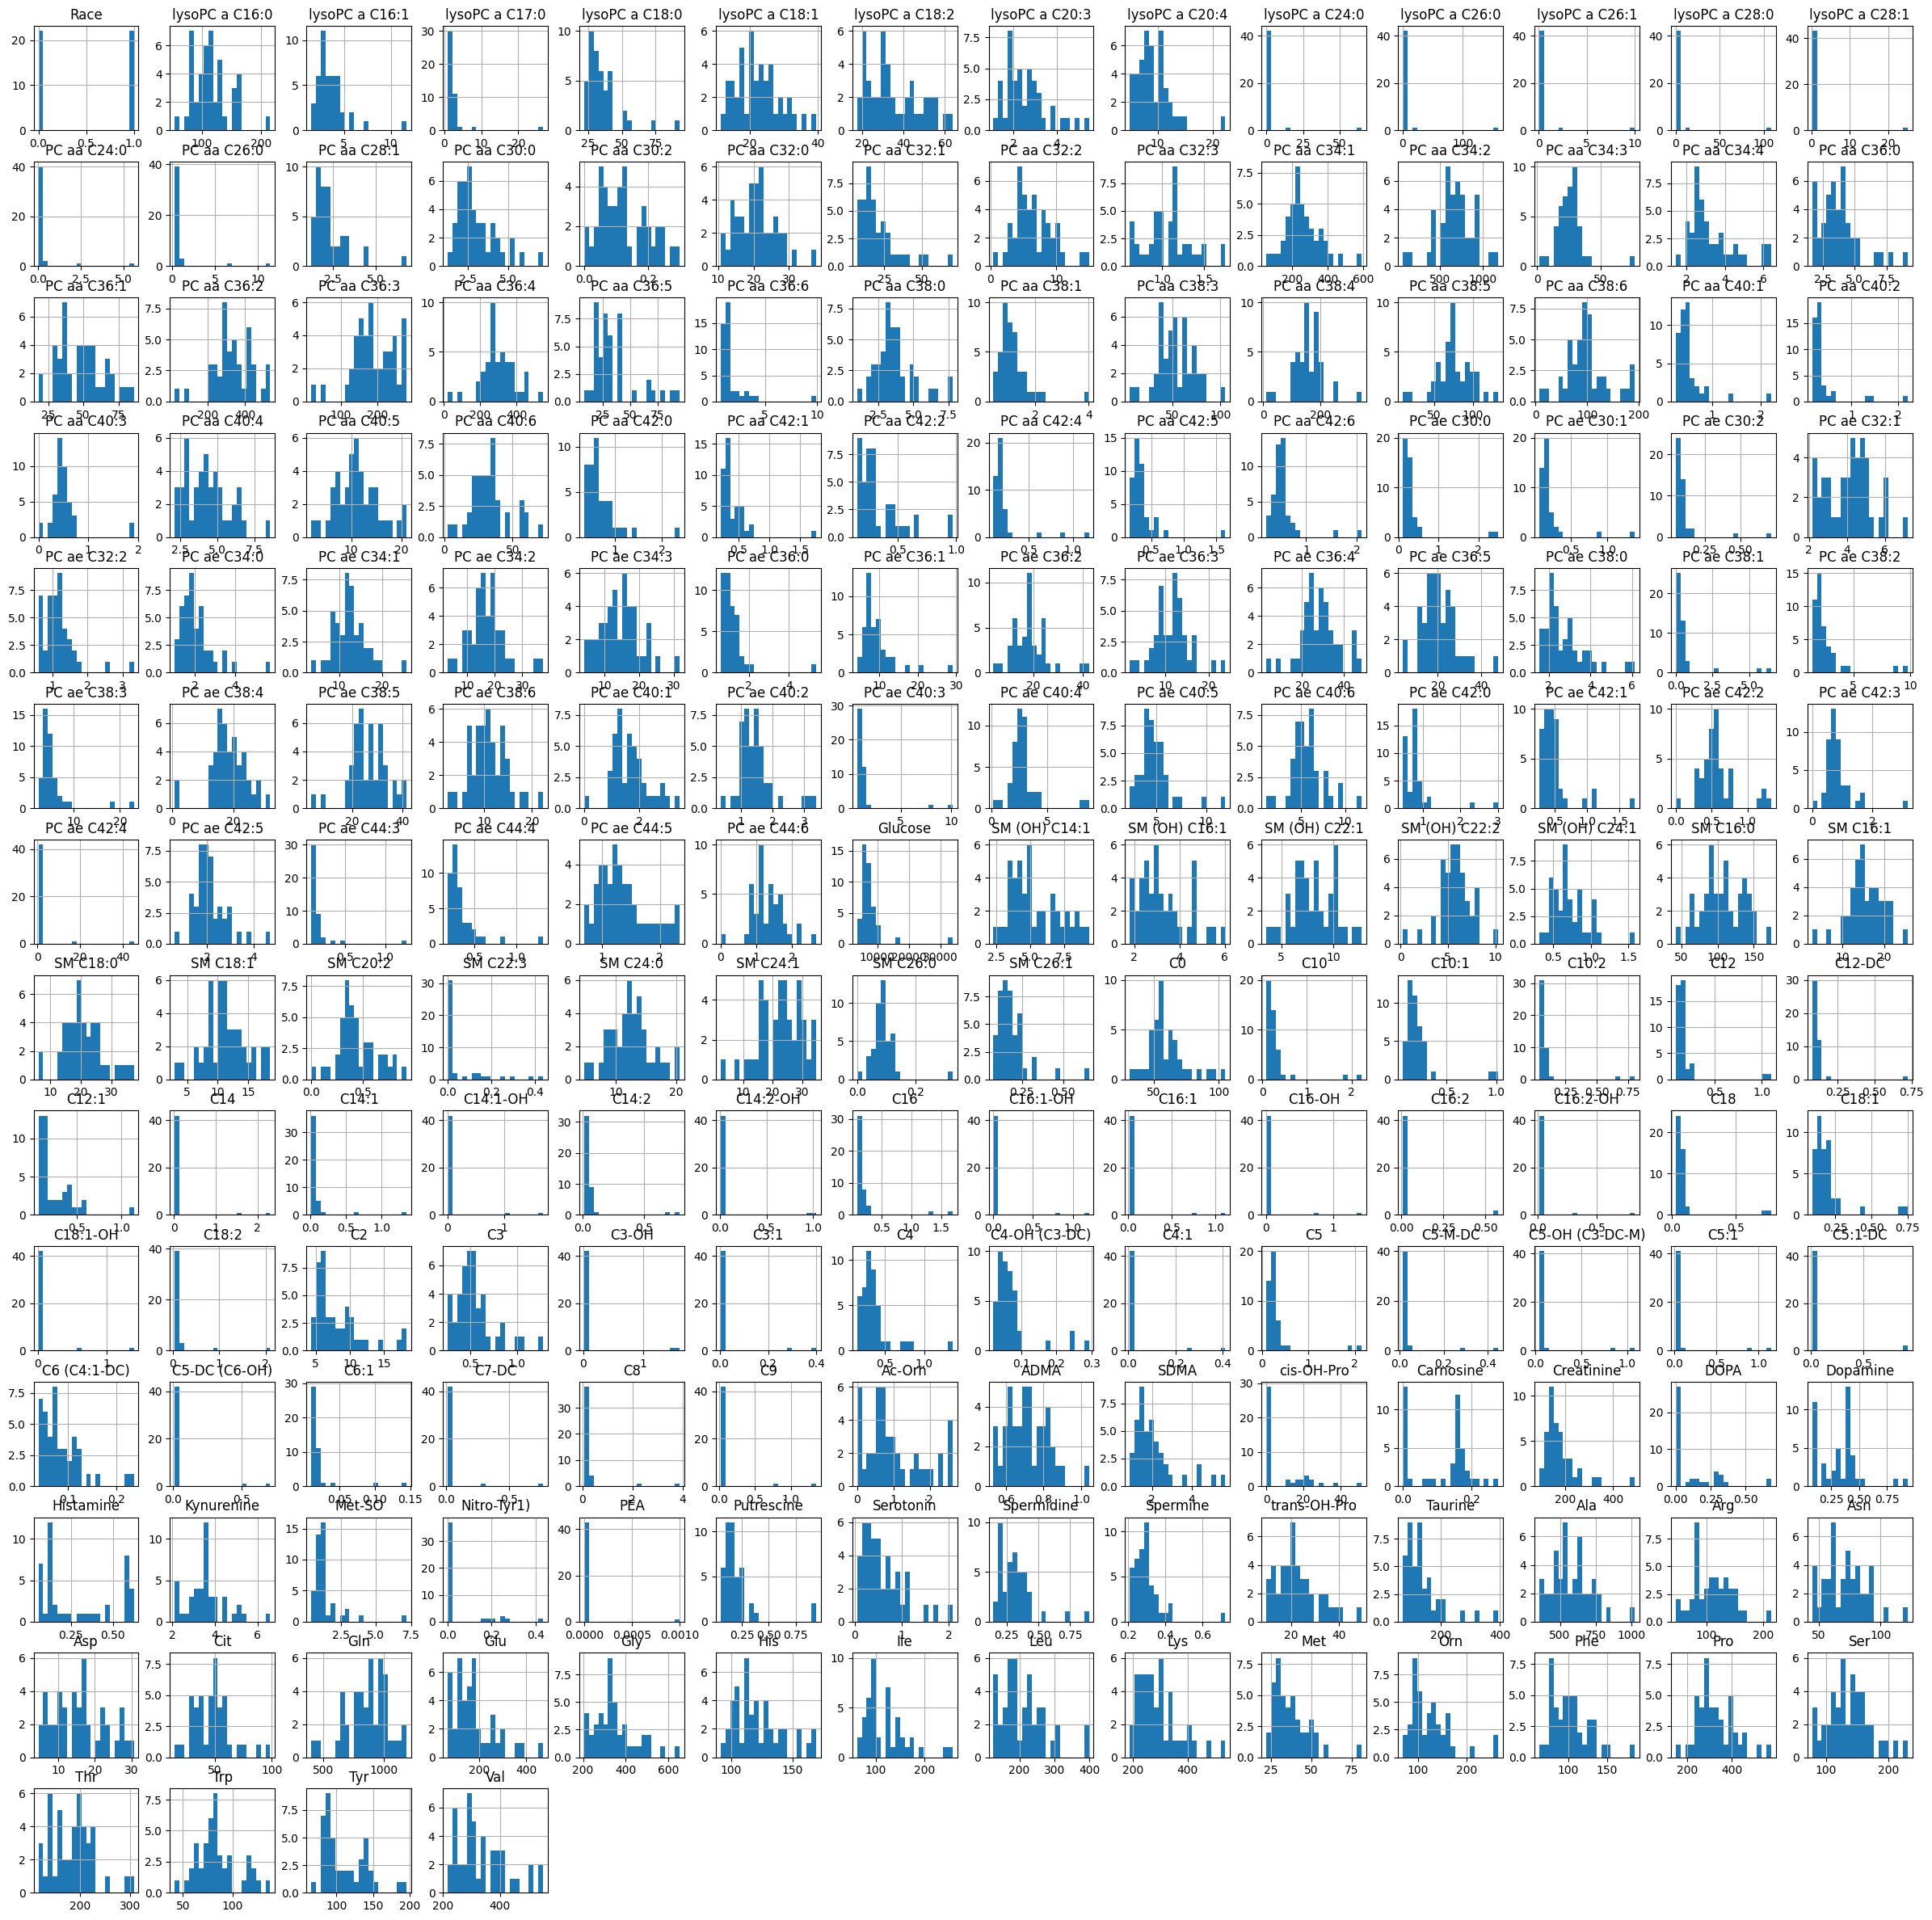

In [ ]:
# Histogram
df1.hist(bins=20, figsize=(30, 30))
plt.show()

Correlation Matrix

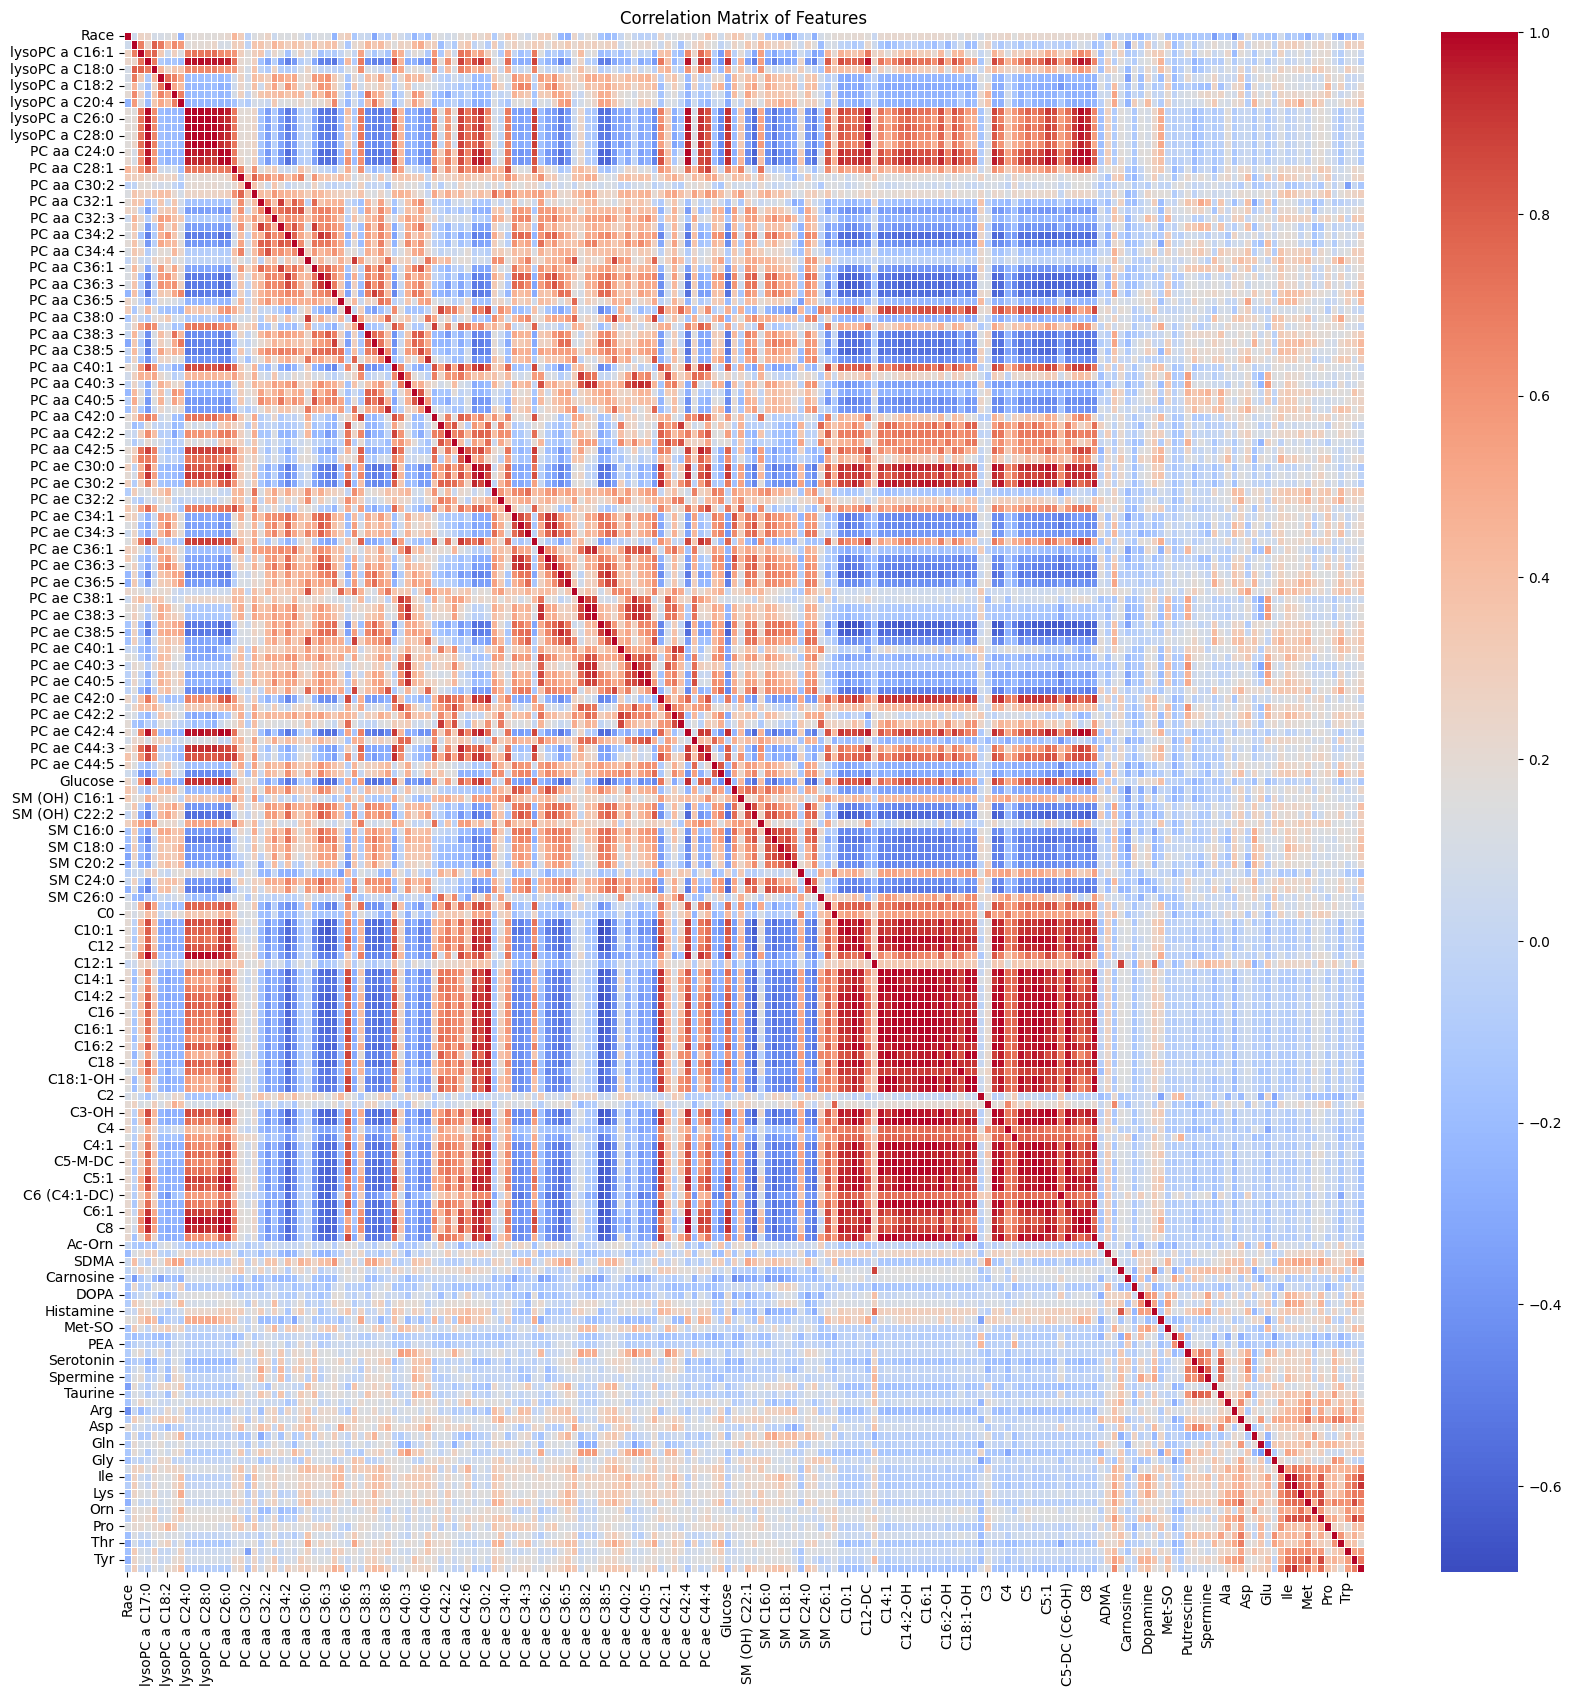

In [ ]:
# Correlation matrix for df1
corr_matrix = df1.corr()

# Plotting the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()


In [ ]:
# Pearson correlation coefficients
pearson_correlation = df1.corr(method='pearson')
# print(pearson_correlation)
pearson_correlation

,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,lysoPC a C24:0,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
Race,1.000000,0.064401,0.259098,0.237775,0.095838,0.100196,0.138340,0.192784,-0.239085,0.185376,...,-0.150790,-0.251611,-0.022212,-0.067447,0.131101,-0.183484,-0.307417,-0.167472,-0.246011,-0.045243
lysoPC a C16:0,0.064401,1.000000,0.676783,0.237713,0.783281,0.700895,0.449429,0.630471,0.573549,0.161200,...,0.252250,0.164122,0.220864,0.261181,0.206625,0.132019,0.086702,0.319034,0.246543,0.294912
lysoPC a C16:1,0.259098,0.676783,1.000000,0.718214,0.774162,0.327109,0.047940,0.285749,0.134679,0.688899,...,0.169037,0.024401,0.168112,0.184676,0.210874,0.022757,-0.065594,0.096239,0.131903,0.027454
lysoPC a C17:0,0.237775,0.237713,0.718214,1.000000,0.694046,-0.090364,-0.155422,-0.134843,-0.186257,0.987051,...,0.131216,0.034280,0.183129,0.229318,0.150266,0.042487,-0.084862,0.066717,0.091828,-0.051247
lysoPC a C18:0,0.095838,0.783281,0.774162,0.694046,1.000000,0.440606,0.239099,0.361460,0.343320,0.631438,...,0.270377,0.166762,0.341390,0.304189,0.215758,0.162613,0.085208,0.294931,0.212068,0.168397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ser,-0.183484,0.132019,0.022757,0.042487,0.162613,0.141441,0.097398,0.137072,0.116680,0.007351,...,0.377554,0.662111,0.240693,0.491511,0.267251,1.000000,0.592891,0.325770,0.458835,0.316011
Thr,-0.307417,0.086702,-0.065594,-0.084862,0.085208,0.202169,0.284019,0.029675,0.177101,-0.108678,...,0.441201,0.607274,0.326692,0.307077,0.259688,0.592891,1.000000,0.375580,0.366500,0.161352
Trp,-0.167472,0.319034,0.096239,0.066717,0.294931,0.020216,0.008728,0.106198,0.276044,0.035547,...,0.619577,0.600970,0.584801,0.579730,0.166855,0.325770,0.375580,1.000000,0.555968,0.554502
Tyr,-0.246011,0.246543,0.131903,0.091828,0.212068,0.029496,0.059430,0.201406,0.250433,0.070996,...,0.693630,0.846545,0.457896,0.865272,0.380423,0.458835,0.366500,0.555968,1.000000,0.683455


In [ ]:
# Get correlation of all features with 'Race'
race_correlation = pearson_correlation['Race']
print(race_correlation)

Race              1.000000
lysoPC a C16:0    0.064401
lysoPC a C16:1    0.259098
lysoPC a C17:0    0.237775
lysoPC a C18:0    0.095838
                    ...   
Ser              -0.183484
Thr              -0.307417
Trp              -0.167472
Tyr              -0.246011
Val              -0.045243
Name: Race, Length: 186, dtype: float64


Spearman Rank Correlation (for non-linear relationships)

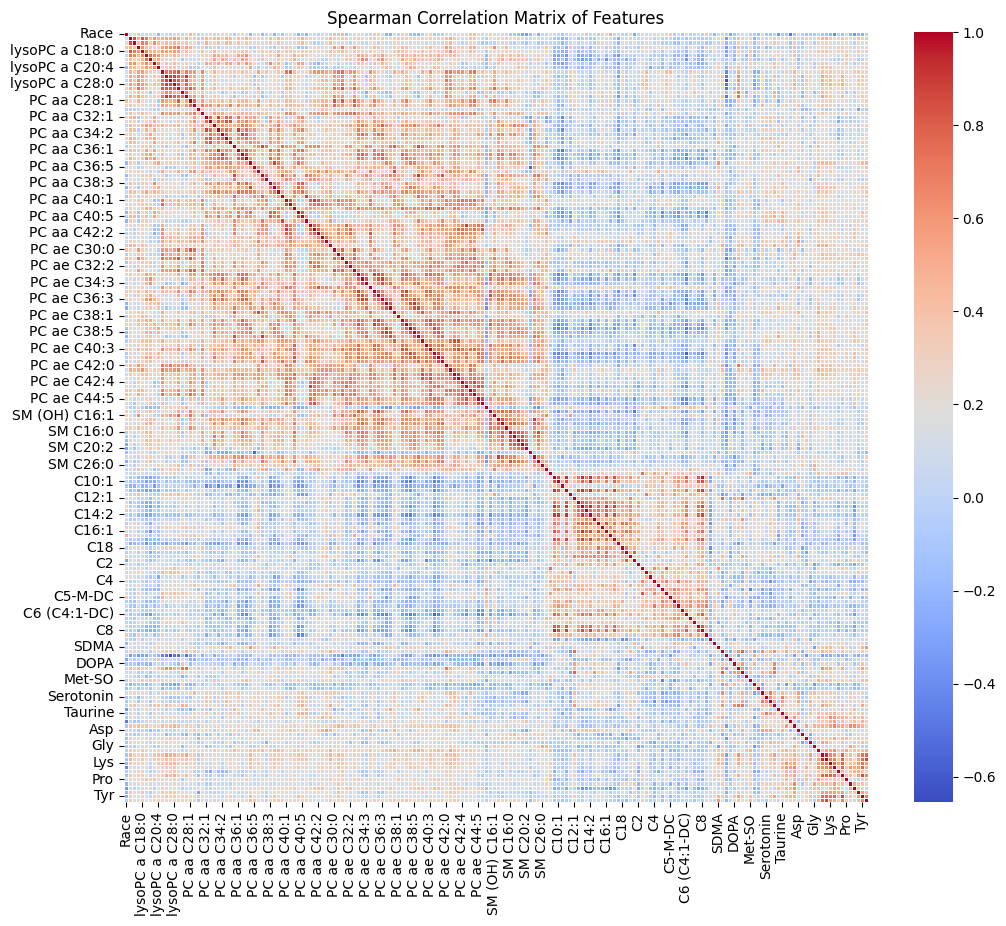

In [ ]:
# Spearman correlation matrix
spearman_corr = df1.corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Spearman Correlation Matrix of Features')
plt.show()


In [ ]:
spearman_corr

,Race,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,lysoPC a C24:0,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
Race,1.000000,0.132476,0.191526,0.383065,0.078753,0.073401,0.093071,0.207657,-0.198693,0.170034,...,-0.196910,-0.420641,-0.048327,-0.134261,0.091285,-0.209470,-0.359833,-0.207635,-0.255955,-0.042965
lysoPC a C16:0,0.132476,1.000000,0.855340,0.502133,0.834062,0.712463,0.429790,0.605633,0.474321,0.492951,...,0.354202,0.224956,0.212541,0.368809,0.297945,0.162530,0.038215,0.385055,0.302774,0.370479
lysoPC a C16:1,0.191526,0.855340,1.000000,0.391147,0.704715,0.656350,0.287919,0.626273,0.442110,0.344587,...,0.233611,0.115387,0.120599,0.224278,0.229709,0.093873,-0.026718,0.245506,0.185128,0.145153
lysoPC a C17:0,0.383065,0.502133,0.391147,1.000000,0.617797,0.421179,0.309216,0.261650,0.253736,0.553233,...,0.288393,0.094068,0.327694,0.314522,0.167653,0.249410,0.062110,0.247665,0.123493,0.254080
lysoPC a C18:0,0.078753,0.834062,0.704715,0.617797,1.000000,0.676606,0.458383,0.484686,0.421568,0.589717,...,0.292627,0.194178,0.309053,0.318965,0.310533,0.205287,0.118427,0.373696,0.222645,0.297935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ser,-0.209470,0.162530,0.093873,0.249410,0.205287,0.188450,0.079767,0.099383,0.121867,0.202044,...,0.383099,0.589502,0.331912,0.444844,0.167930,1.000000,0.517981,0.384342,0.399485,0.268862
Thr,-0.359833,0.038215,-0.026718,0.062110,0.118427,0.211317,0.230509,-0.042056,0.179809,0.337375,...,0.411273,0.548537,0.463960,0.129799,0.145853,0.517981,1.000000,0.376701,0.245497,0.017450
Trp,-0.207635,0.385055,0.245506,0.247665,0.373696,0.036836,-0.083028,0.093194,0.165404,0.376586,...,0.578775,0.575844,0.507313,0.567410,0.024952,0.384342,0.376701,1.000000,0.572405,0.419422
Tyr,-0.255955,0.302774,0.185128,0.123493,0.222645,0.100987,-0.020087,0.300331,0.290971,0.270642,...,0.726465,0.772229,0.392726,0.861025,0.315830,0.399485,0.245497,0.572405,1.000000,0.664129


In [ ]:
# Get correlation of all features with 'Race'
race_correlation = spearman_corr['Race']
print(race_correlation)

Race              1.000000
lysoPC a C16:0    0.132476
lysoPC a C16:1    0.191526
lysoPC a C17:0    0.383065
lysoPC a C18:0    0.078753
                    ...   
Ser              -0.209470
Thr              -0.359833
Trp              -0.207635
Tyr              -0.255955
Val              -0.042965
Name: Race, Length: 186, dtype: float64


Mutual Information (non-linear relationships)

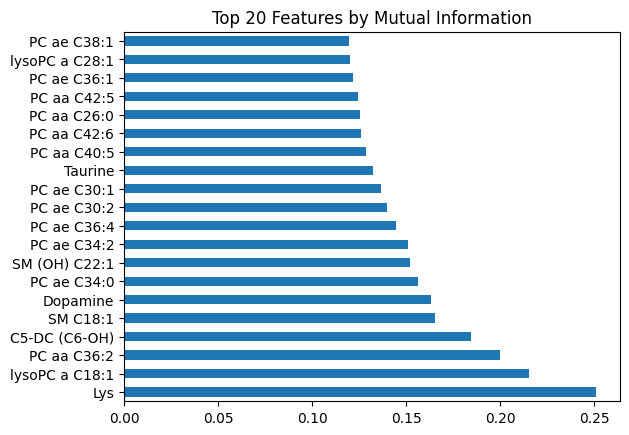

In [ ]:
# Compute mutual information between features and target
mi = mutual_info_classif(df1.drop(columns=['Race']), df1['Race'])

# Create a DataFrame of the results
mi_df = pd.Series(mi, index=df1.columns[:-1]).sort_values(ascending=False)

# Plot top 20 features with highest mutual information
mi_df.head(20).plot(kind='barh')
plt.title('Top 20 Features by Mutual Information')
plt.show()


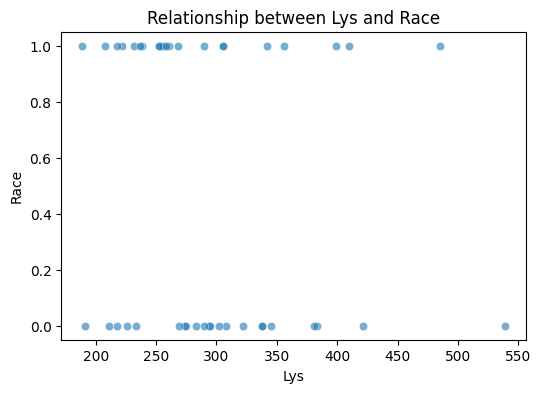

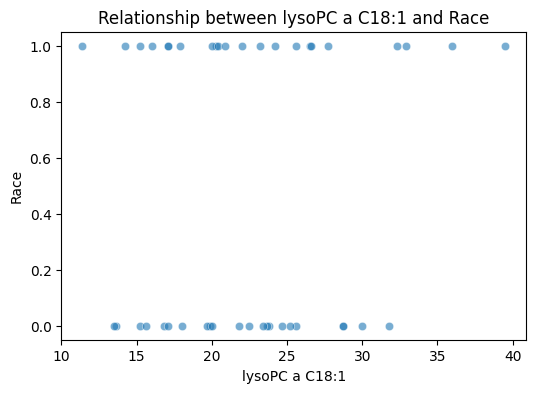

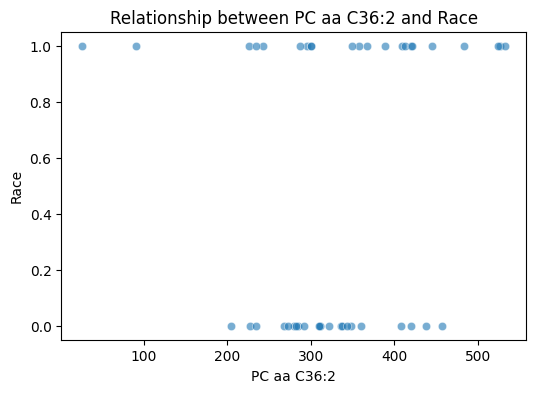

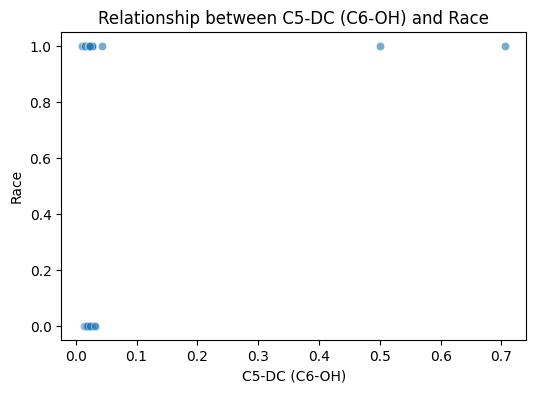

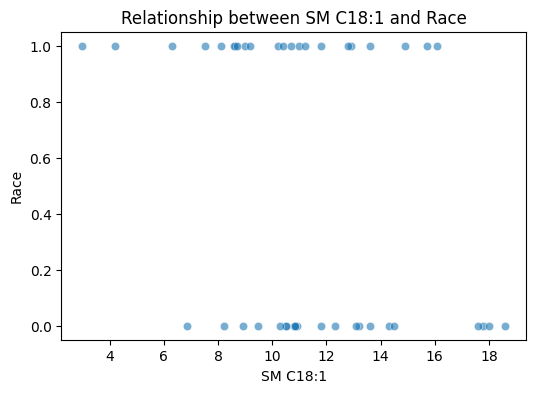

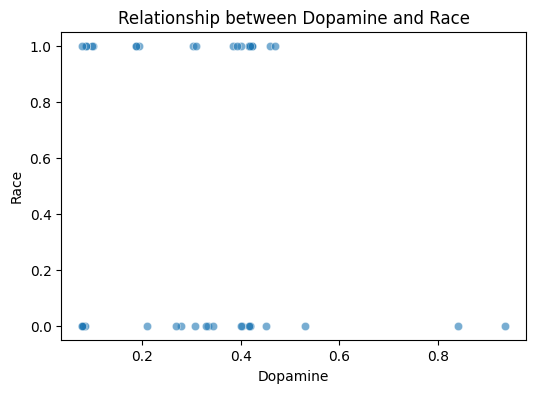

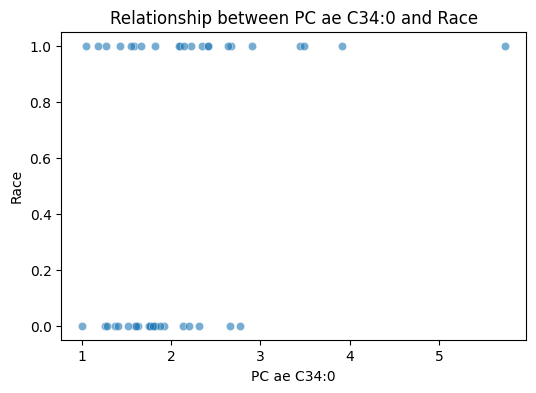

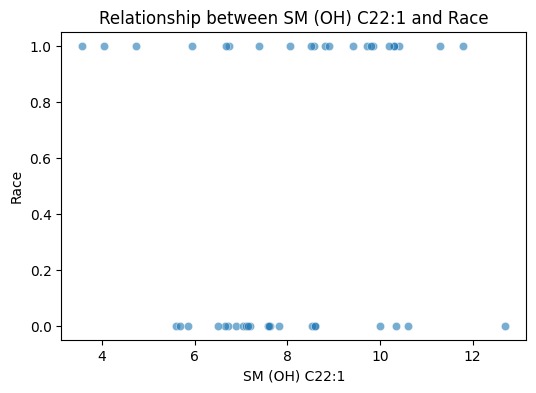

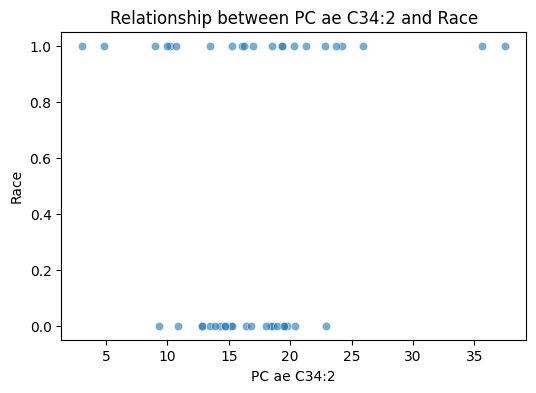

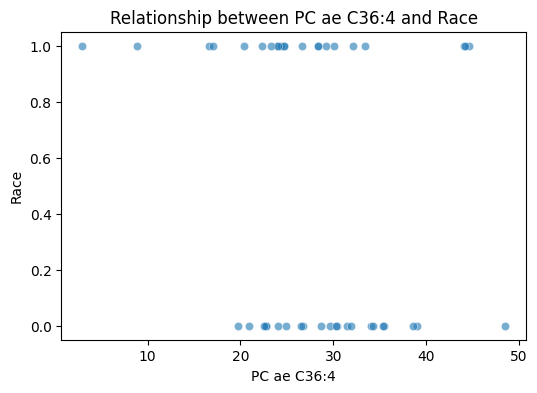

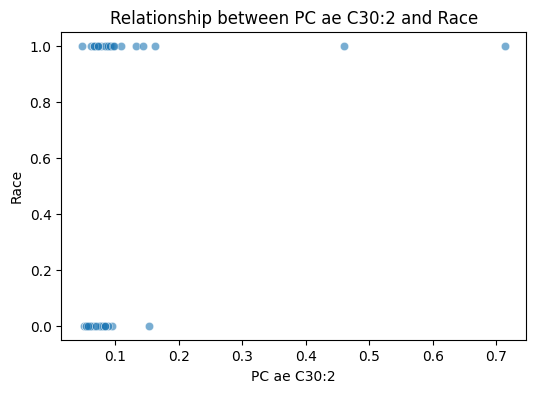

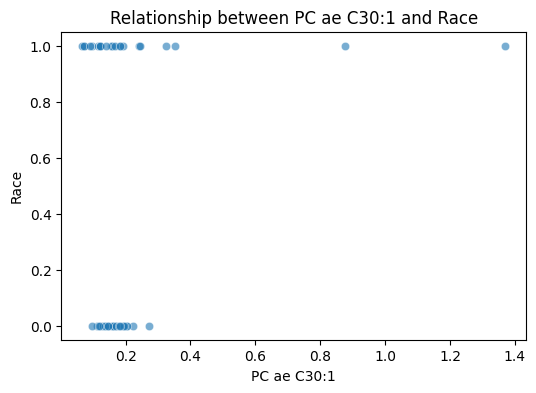

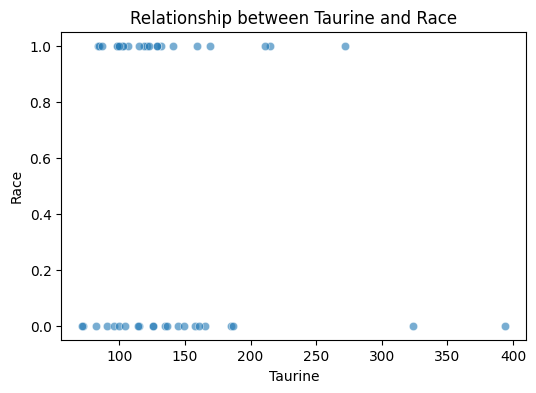

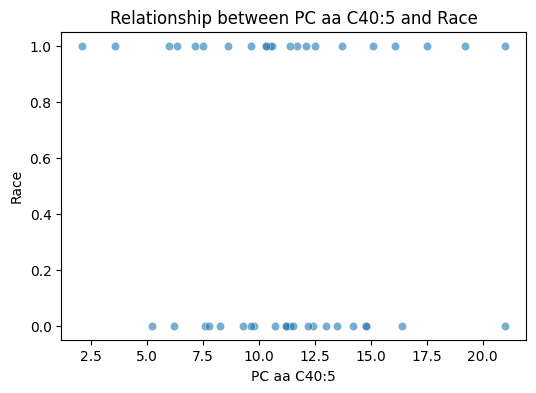

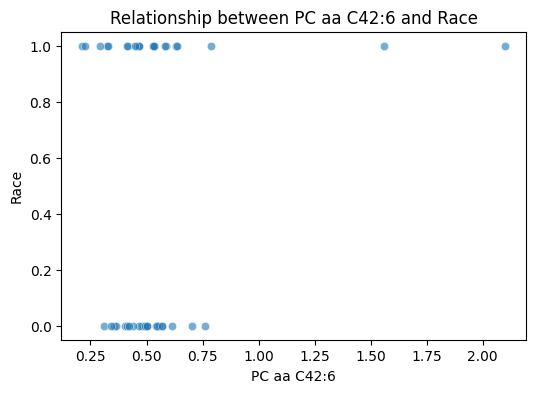

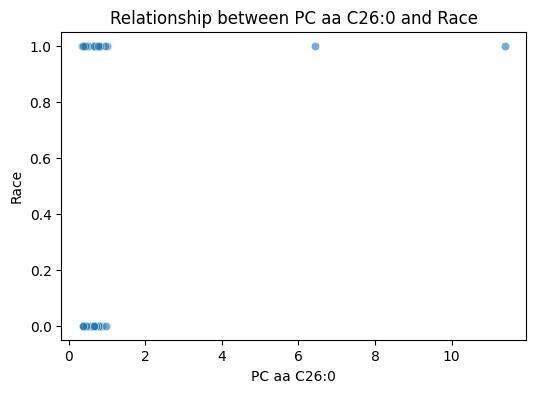

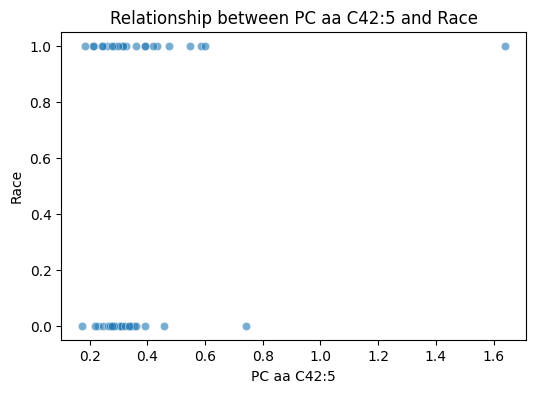

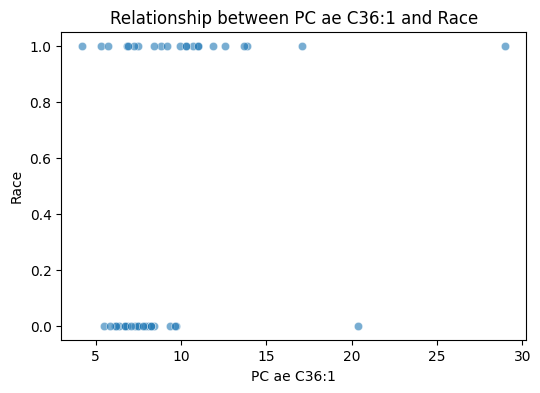

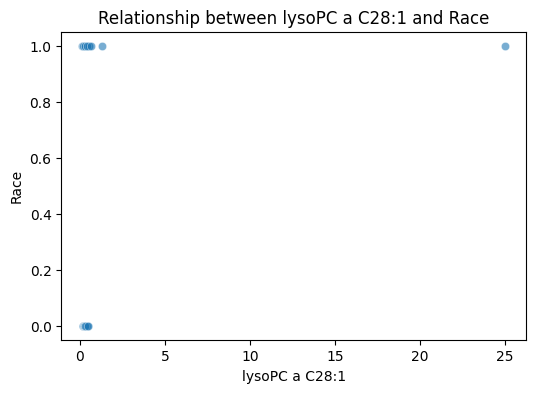

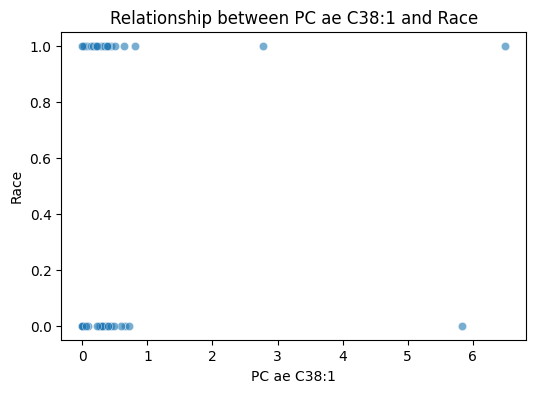

In [ ]:
# Get the top 20 features based on mutual information
top_20_features = mi_df.head(20).index.tolist()

for feature in top_20_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df1[feature], y=df1['Race'], alpha=0.6)
    plt.title(f'Relationship between {feature} and Race')
    plt.xlabel(feature)
    plt.ylabel('Race')
    plt.show()


In [ ]:
# Group by Race and calculate mean for all columns
df1.groupby('Race').median()

,lysoPC a C16:0,lysoPC a C16:1,lysoPC a C17:0,lysoPC a C18:0,lysoPC a C18:1,lysoPC a C18:2,lysoPC a C20:3,lysoPC a C20:4,lysoPC a C24:0,lysoPC a C26:0,...,Lys,Met,Orn,Phe,Pro,Ser,Thr,Trp,Tyr,Val
Race,,,,,,,,,,,,,,,,,,,,,
0,110.0,2.935,1.6875,30.65,22.15,32.00,2.235,8.795,0.164,0.194,...,294.5,41.55,118.0,106.00,300.0,145.5,200.0,83.75,119.5,302.5
1,117.0,3.450,2.0100,35.05,21.45,31.35,2.755,8.440,0.200,0.222,...,257.0,29.70,113.5,94.65,327.0,127.5,165.5,78.25,93.1,306.0


Outlier detection


In [ ]:
# Outlier detection
z_scores = np.abs(stats.zscore(df1.select_dtypes(include=[np.number])))
outliers = df1[(z_scores > 3).any(axis=1)]
print(outliers)


    Race  lysoPC a C16:0  lysoPC a C16:1  lysoPC a C17:0  lysoPC a C18:0  \
5      0           118.0           2.950           2.420           34.80   
13     1           163.0          11.700          26.700           92.80   
18     0           111.0           2.910           1.220           26.70   
21     1           156.0           5.860           1.940           42.10   
23     1            54.6           2.140           8.120           28.50   
27     0           117.0           3.580           1.780           30.80   
29     0           118.0           4.460           1.155           28.45   
32     0           133.5           4.375           2.360           52.85   
36     0           109.0           3.790           1.520           31.00   
39     1           121.0           2.850           2.950           38.80   
42     0           104.3           4.065           1.630           30.60   
44     1           130.0           3.880           1.730           34.20   
54     0    

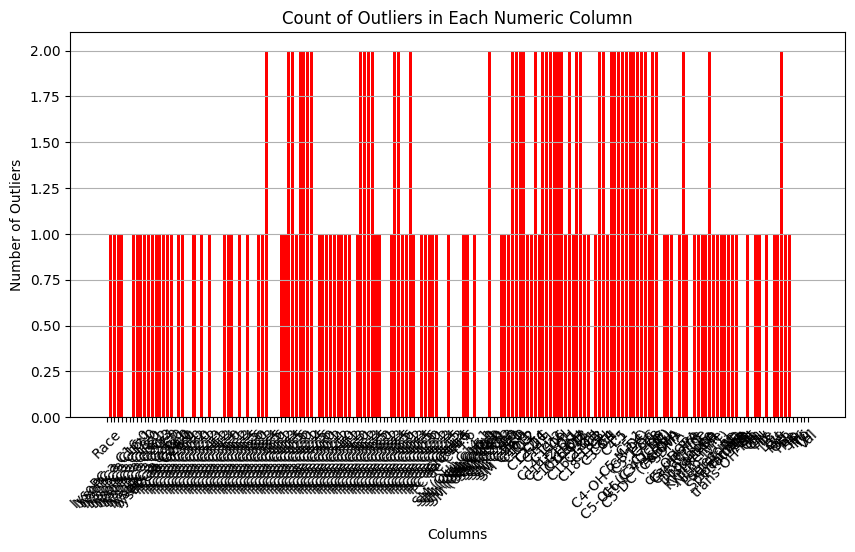

In [ ]:
# Count outliers in each column
outlier_counts = (z_scores > 3).sum(axis=0)

# Create a bar plot for the outliers
plt.figure(figsize=(10, 5))
plt.bar(df1.select_dtypes(include=[np.number]).columns, outlier_counts, color='red')
plt.title('Count of Outliers in Each Numeric Column')
plt.xlabel('Columns')
plt.ylabel('Number of Outliers')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()

#Model

In [ ]:
X = df1.drop(columns=['Race'])
y = df1['Race']

# Create Train & Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,
                                                	stratify =y,
                                                	random_state = 43)


# Random Forest Classifier
rf_clf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
rf_clf_best = grid_search.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
# Cross validation
scores = cross_val_score(rf_clf_best, X, y, cv=5)
print("Cross-validation scores: ", scores)
print("Mean CV score: ", scores.mean())

Cross-validation scores:  [0.55555556 0.88888889 0.66666667 0.55555556 0.75      ]
Mean CV score:  0.6833333333333333


In [ ]:
rf_clf_best.fit(X_train, y_train)

y_pred_best = rf_clf_best.predict(X_test)

# Classification Report
print(classification_report(y_pred_best, y_test))


              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.25      0.50      0.33         2

    accuracy                           0.56         9
   macro avg       0.53      0.54      0.50         9
weighted avg       0.68      0.56      0.59         9



Feature Importance

X columns: 185
Feature importances: 185
         Feature  Importance
15   PC aa C28:1    0.047148
51   PC ae C30:0    0.040218
57   PC ae C34:1    0.034122
86   PC ae C44:4    0.023656
75   PC ae C40:3    0.023552
..           ...         ...
151         DOPA    0.000349
88   PC ae C44:6    0.000317
156  Nitro-Tyr1)    0.000307
122     C16:2-OH    0.000204
157          PEA    0.000000

[185 rows x 2 columns]


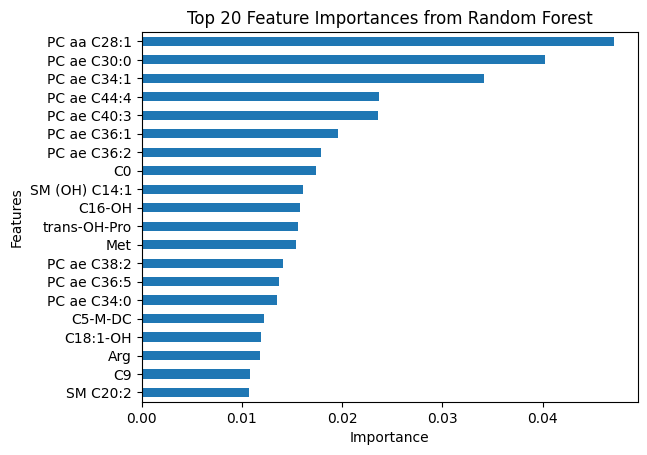

In [ ]:
# Get feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_clf_best.feature_importances_})
print(f"X columns: {len(X_train.columns)}")
print(f"Feature importances: {len(rf_clf_best.feature_importances_)}")

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

# Sort by importance and display the top 20 important features
top_features = feature_importances.nlargest(20, 'Importance')

# Plot the top 20 important features in descending order
top_features.sort_values(by='Importance', ascending=True).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title('Top 20 Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


Recursive Feature Elimination (RFE):

In [ ]:
# Initialize RandomForest and RFE
rfe = RFE(estimator=rf_clf_best, n_features_to_select=20)  # Select top 20 features

# Fit RFE on the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

print("Selected Features:", selected_features)


Selected Features: Index(['PC aa C28:1', 'PC ae C30:0', 'PC ae C30:2', 'PC ae C34:1',
       'PC ae C36:1', 'PC ae C36:2', 'PC ae C36:4', 'PC ae C38:2',
       'PC ae C40:3', 'PC ae C44:4', 'SM (OH) C14:1', 'SM C20:2', 'SM C24:1',
       'C0', 'C16-OH', 'C18:2', 'C5-M-DC', 'C9', 'trans-OH-Pro', 'Arg'],
      dtype='object')


# dimensionality reduction

PCA

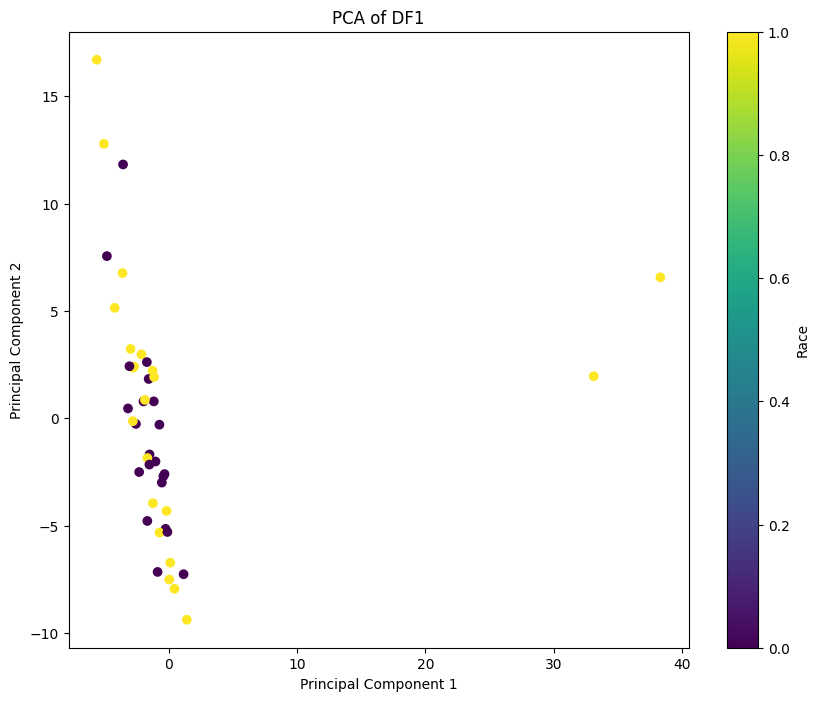

In [ ]:
# Standardize the data
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

# Performing PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data = principal_components, columns = ['Principal Component 1', 'Principal Component 2'])

# Visualize the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], c=df1['Race'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of DF1')
plt.colorbar(label='Race')
plt.show()



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(principal_components, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=43)

rf_clf_best.fit(X_train, y_train)

y_pred_best = rf_clf_best.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred_best))


              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.50      0.75      0.60         4

    accuracy                           0.56         9
   macro avg       0.58      0.57      0.55         9
weighted avg       0.59      0.56      0.54         9



PacMap

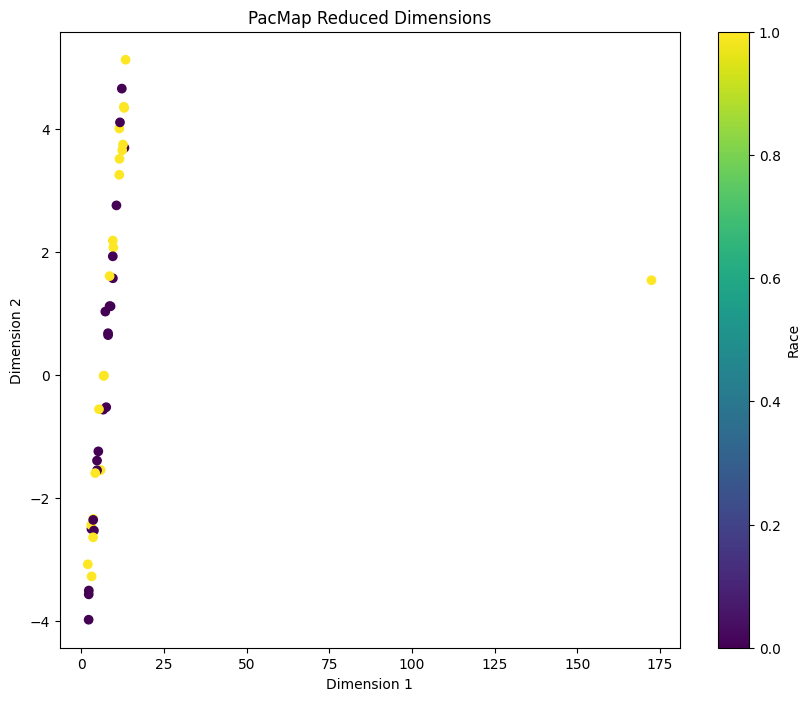

              precision    recall  f1-score   support

           0       0.25      0.20      0.22         5
           1       0.20      0.25      0.22         4

    accuracy                           0.22         9
   macro avg       0.23      0.23      0.22         9
weighted avg       0.23      0.22      0.22         9



In [ ]:
# Dimensionality reduction using PaCMAP
pacmap_model = pacmap.PaCMAP()
pacmap = pacmap_model.fit_transform(X)


plt.figure(figsize=(10, 8))
plt.scatter(pacmap[:, 0], pacmap[:, 1], c=df1['Race'], cmap='viridis')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('PacMap Reduced Dimensions')
plt.colorbar(label='Race')
plt.show()


X_train, X_test, y_train, y_test = train_test_split(pacmap, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=43)

rf_clf_best.fit(X_train, y_train)

y_pred_best = rf_clf_best.predict(X_test)

print(classification_report(y_test, y_pred_best))

# SHAP

Variable Importance Plot - Global Interpretation


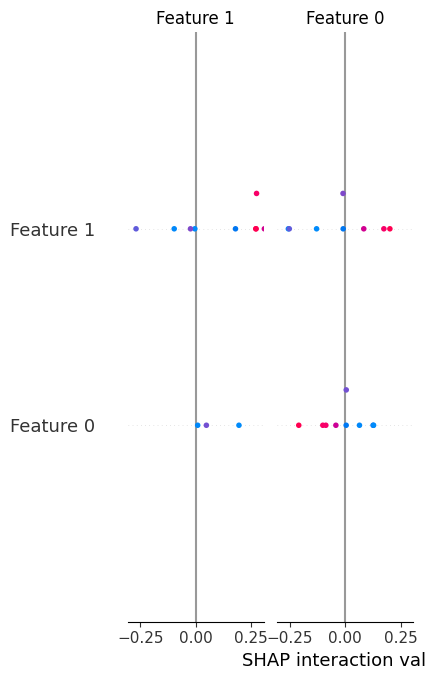

In [ ]:
# Create SHAP explainer for tree-based models
explainer = shap.TreeExplainer(rf_clf_best)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

print("Variable Importance Plot - Global Interpretation")
# plt.figure()
shap.summary_plot(shap_values, X_test)


In [ ]:
# # Create SHAP explainer for the Random Forest model
# explainer = shap.TreeExplainer(rf_clf_best)

# # Calculate SHAP values for the test set
# shap_values = explainer.shap_values(X_test)

# # Check the shape of SHAP values
# print("SHAP values shape:", [sv.shape for sv in shap_values])

# # Summary plot to visualize global feature importance
# # Access SHAP values for the specific class (e.g., class index 0 for binary or first class)
# shap.summary_plot(shap_values[1], X_test, feature_names=['Component 1', 'Component 2'])


#LIME

In [ ]:
# Initialize the explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=df1.columns.drop('Race'),
    class_names=['Case control', 'Prostate Cancer'],
    mode='classification'
)

# Choose an instance to explain
i = 5
exp = explainer.explain_instance(X_test[i], rf_clf_best.predict_proba, num_features=180)

# Show the explanation
exp.show_in_notebook(show_table=True)